# In this example I will show how you can use redback to estimate the bolometric luminosity of a transient

In [1]:
import redback
from redback.simulate_transients import SimulateGenericTransient
from astropy.cosmology import Planck18 as cosmo
%pylab inline

20:24 bilby INFO    : Running bilby version: 2.3.1.dev100+g65bcde32
20:24 redback INFO    : Running redback version: 1.0.31


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


We first fake some data, so let's set the parameters

In [3]:
np.random.seed(1236)

bands = ['lsstg', 'lsstr', 'lssti', 'lsstu', 'lsstz']

# let's also add some sensible colours to the plot
band_colors = {'lsstg':'green', 'lsstr':'red',
                'lssti':'orange', 'lsstu':'blue', 'lsstz':'violet'}

times = np.geomspace(0.5, 50, 100)
times = np.append(times, np.linspace(50, 200, 100))
kappa = 0.07
kappa_gamma = 0.1
mej = 4
vej = 20000
nickel_mass = 1.5
tf = 1600
f_nickel = nickel_mass/mej

output_format = 'magnitude'
model_kwargs = {'output_format':output_format, 'bands':bands}
num_of_data_points = 650 # the number of data points to generate
parameters = {}
parameters['kappa'] = kappa
parameters['kappa_gamma'] = kappa_gamma
parameters['f_nickel'] = f_nickel
parameters['mej'] = mej
parameters['vej'] = vej
parameters['temperature_floor'] = tf
parameters['redshift'] = 0.1
distance = cosmo.luminosity_distance(parameters['redshift']).cgs.value

We will need the true output to compare to

In [4]:
func = redback.model_library.all_models_dict['arnett_bolometric']
lbol = func(times, f_nickel=f_nickel, mej=mej, vej=vej, kappa=kappa,
                         kappa_gamma=kappa_gamma, temperature_floor=tf)

Generate some fake data with the simulation module and create the transient object

21:40 redback WARNING : [Errno 2] No such file or directory: 'supernova//Suntan_metadata.csv'
21:40 redback WARNING : Setting metadata to None. This is not an error, but a warning that no metadata could be found online.


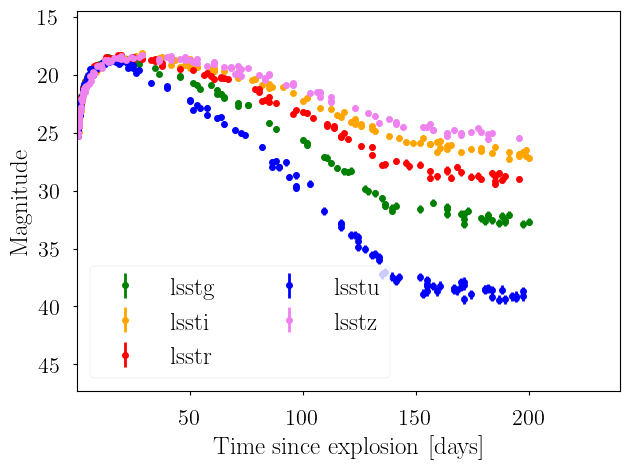

<Axes: xlabel='Time since explosion [days]', ylabel='Magnitude'>

In [30]:
kn_obs = SimulateGenericTransient(model='arnett', parameters=parameters, times=times,
                                  data_points=num_of_data_points, model_kwargs=model_kwargs,
                                 multiwavelength_transient=True, noise_term=0.01)

transient = redback.transient.Supernova(name='Suntan',
                                       magnitude=kn_obs.data['output'].values,
                                      time=kn_obs.data['time'].values,
                                       data_mode=output_format,
                                      magnitude_err=kn_obs.data['output_error'].values,
                                      bands=kn_obs.data['band'].values,
                                       redshift=parameters['redshift'])
transient.plot_data(band_colors=band_colors)

### Now remember we used the arnett model which uses a blackbody SED under the hood. 

The interface for lbol estimation is similar to estimating blackbody temperature and radius, so please look there for more details. The API docs are also a good place to look..

You can do this for yourself for anything in jupyter using e.g., 
    
    transient.estimate_bololmetric_luminosity?`
   
In particular we need to pass a dsitance, a bin_width, and a minimum number of filters where:

**bin_width**: is the width of the time bins in days for grouping photometry

**min filters**: is the minimum number of independent filters required in a bin 

Additionally we can also pass optional keywords

**lambda_cut**: in angstroms, the bolometric luminosity will be boosted to account for flux missing (or blanketed) below this wavelength. This is comprable to the Cutoff blackbody in redback or what the superbol code also does.

**A_ext**: Magnitude of extinction in the photometry, this is "removed" from the bolometric estimate

The function also passes any other keyword arguments to the estimate_bb_params method.

In [28]:
df = transient.estimate_bolometric_luminosity(distance, 
                                                 lambda_cut=4000, 
                                                 min_filters=5, 
                                                A_ext=0.0)

21:35 redback INFO    : Including effects of missing flux due to line blanketing.
21:35 redback INFO    : Using lambda_cut = 4000 Å for bolometric luminosity boost.
21:35 redback INFO    : Estimating blackbody parameters for my_kilonova.
21:35 redback INFO    : Using data mode = magnitude
21:35 redback INFO    : Number of bins: 201
21:35 redback INFO    : Masking epochs with likely wrong extractions
21:35 redback INFO    : Masking bolometric estimates with likely wrong extractions
21:35 redback INFO    : Estimated bolometric luminosity using blackbody integration (with boost and extinction corrections if specified).


We are returned a pandas dataframe with luminosity columns, errors, time in rest frame. 

Let's plot stuff

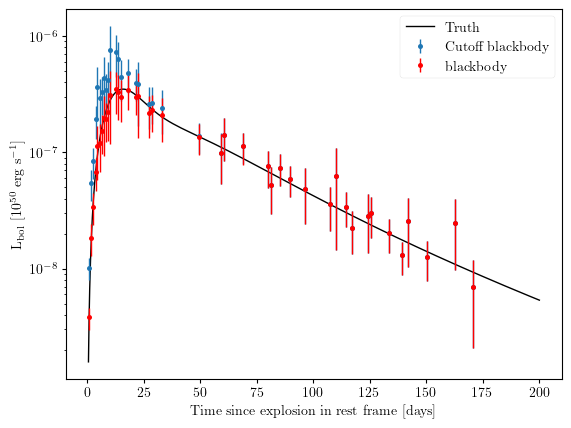

In [29]:
plt.plot(times, lbol/1e50, c='black', label='Truth')
plt.errorbar(df['time_rest_frame'], df['lum_bol'], df['lum_bol_err'], 
             fmt='o', label='Cutoff blackbody')

plt.errorbar(df['time_rest_frame'], df['lum_bol_bb'], df['lum_bol_bb_err'], 
             fmt='o', color='red', label='blackbody')
plt.yscale('log')

plt.ylabel(r"L$_{\rm bol}$ [$10^{50}$ erg s$^{-1}$]")
plt.xlabel('Time since explosion in rest frame [days]')

plt.legend()

Keep in mind that the arnett model assumes a blackbody and we assumed no extinction when we simulated the data, so its great that our red blackbody luminosities are consistent with the truth. 

A note - when plotting in log with linear errors we should be using asymmetrical errorbars. But I am lazy. 

We can do similar things like we did in the GP/blackbody notebooks e.g., plot GP interpolations on top and generate new data as well. The analysis module provides some tools for that.

But what might be more useful is that we can use this data to generate a the bolometric luminosity transient object which we can use to fit models in bolometric luminosity space, which tends to be a lot quicker and may be safer to some assumptions about photospheres etc. 

21:44 redback WARNING : [Errno 2] No such file or directory: 'supernova//suntan_lbol_metadata.csv'
21:44 redback WARNING : Setting metadata to None. This is not an error, but a warning that no metadata could be found online.


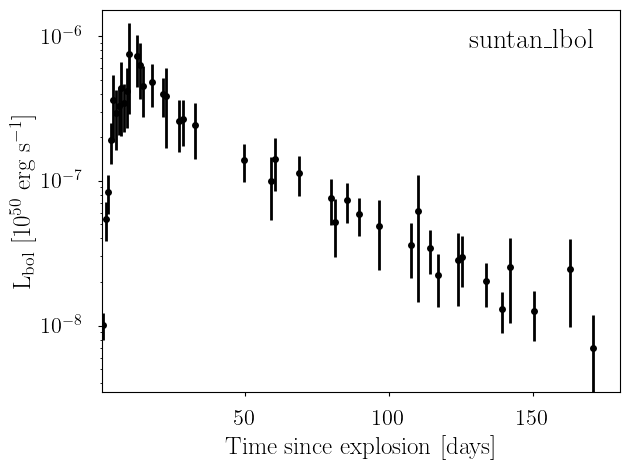

In [37]:
sn = redback.transient.Supernova(name='suntan_lbol', Lum50=df['lum_bol'].values,
                                Lum50_err = df['lum_bol_err'].values, 
                                 time_rest_frame=df['time_rest_frame'].values,
                                data_mode='luminosity')
ax = sn.plot_data(show=False, xlim_high=180)
ax.set_xscale('linear')

Keep in mind that while above we used time since explosion, the method does not really care what the time itself is in question so you could work just as well in mjds.

# Now you should hopefully know how to use redback to get bolometric luminosity estimates of optical transients